In [ ]:
! pip install bertopic nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 84.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

In [ ]:
news_data = pd.read_csv("./bbc-news-data.csv", sep="\t")
news_data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# Data Preprocessing
- stopwords, alphabet이 아닌 word 제거
- 길이가 3 이하인 단어 제거
- 빈도수가 낮은 word 제거 (제거 기준: 5개 이하)
- 소문자 변환
- `vocab_to_index`, `index_to_vocab` dictionary 정의
- text data를 index로 변환

In [ ]:
news_df = pd.DataFrame({'document': news_data["content"]})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ", regex=True)

# 길이가 3 이하인 단어는 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

# stopwords 제거
nltk.download('stopwords')
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 불용어 제거
nltk.download('stopwords')
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = []

for i in range(tokenized_doc.shape[0]): # document 개수
  doc = tokenized_doc[i]
  data.append(doc)

len(data)

2225

In [ ]:
# count word occurrence in corpus
def count_vocab(corpus):
    vocab = defaultdict(int)
    for doc in corpus:
        for word in doc:
            vocab[word] += 1

    return vocab

vocab_count = count_vocab(data)


# only consider valid words with occurrence > cnt
def vocab_top(vocab,cnt):
    temp = defaultdict(int)
    for voca, count in vocab.items():
        if count > cnt:
            temp[voca] = count

    return temp

vocab_count = vocab_top(vocab_count, cnt=5)


# filter out low-occurrence words
def filter_vocab(corpus,vocab):
    data = list()
    for doc in corpus:
        temp = list()
        for word in doc:
            if word in vocab.keys():
                temp.append(word)
        if temp:
            data.append(temp)

    return data

data = filter_vocab(data, vocab_count)

In [ ]:
docs = [' '.join(words) for words in data]
len(docs)

2225

# BERTopic

![](https://maartengr.github.io/BERTopic/algorithm/default.svg)

In [ ]:
# Embeddings
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Dimensionality Reduction
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
# Clustering
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=2, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
from bertopic import BERTopic

num_topics = 5

model = BERTopic(
  # Pipeline models
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,
  nr_topics=num_topics+1,
  calculate_probabilities=True
)

topics, probabilities = model.fit_transform(docs)

2025-12-08 11:24:40,152 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2025-12-08 11:24:49,326 - BERTopic - Embedding - Completed ✓
2025-12-08 11:24:49,335 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-08 11:25:12,599 - BERTopic - Dimensionality - Completed ✓
2025-12-08 11:25:12,600 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-08 11:25:13,308 - BERTopic - Cluster - Completed ✓
2025-12-08 11:25:13,309 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-08 11:25:13,661 - BERTopic - Representation - Completed ✓
2025-12-08 11:25:13,662 - BERTopic - Topic reduction - Reducing number of topics
2025-12-08 11:25:13,674 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-08 11:25:13,982 - BERTopic - Representation - Completed ✓
2025-12-08 11:25:13,985 - BERTopic - Topic reduction - Reduced number of topics from 114 to 6


In [ ]:
# topic이 -1로 할당된 document에 대해 topic 재할당 및 probability 계산
new_topics = model.reduce_outliers(docs, topics, strategy="embeddings")

model.update_topics(docs, topics=new_topics)

new_probs, topic_token_distributions = model.approximate_distribution(docs, calculate_tokens=True)

topics = new_topics
probabilities = new_probs

2025-12-08 11:25:15,115 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


# Analyze Results

In [ ]:
topic_colors = [
    '#D45584',
    '#F4A261',
    '#7BC27F',
    '#5FA8D3',
    '#8E62C9'
]


def topic_word(model, topic, num_words=10): # 각 topic별 나올 확률이 높은 10개의 words
    info = model.get_topic_info()
    words = info.Representation[topic]
    return words

# topic-word proportion visualization
def topic_word_proportion(model):
    html_content = ""
    for i in range(num_topics):
        words = topic_word(model, i)
        color = topic_colors[i % len(topic_colors)]
        topic_header = f'<span style="color:{color}; font-size: 20px; font-weight:bold">TOPIC {i + 1:02}</span>: '
        words_html = ' '.join([f'<span style="font-size: 20px;">{word},</span>' for word in words])
        html_content += f'{topic_header}{words_html}<br><br>'
    return html_content


# document visualization
def document_visualizaion(model, original_docs, idx, doc_nums):
    html_content = ""
    for i in range(doc_nums):
        html_content += f"<span style='font-size:20px; font-weight:bold;'>[DOC {i+idx+1 :04}] </span>"
        for j, original_word in enumerate(original_docs[i+idx]):
            topic_word_prop = topic_token_distributions[i+idx][j]
            if np.max(topic_word_prop) == 0:
                color = ''
            else:
                topic = np.argmax(topic_word_prop)
                color = topic_colors[topic]
            html_content += f'<span style="color:{color}; font-size:20px;">{original_word}</span> '
        html_content += f"<br><br>"
    return html_content

## 1) Topic - Word

In [ ]:
topic_word_proportion_html = topic_word_proportion(model)
display(HTML(f"<html><body>{topic_word_proportion_html}</body></html>"))

## 2) Document - Topic

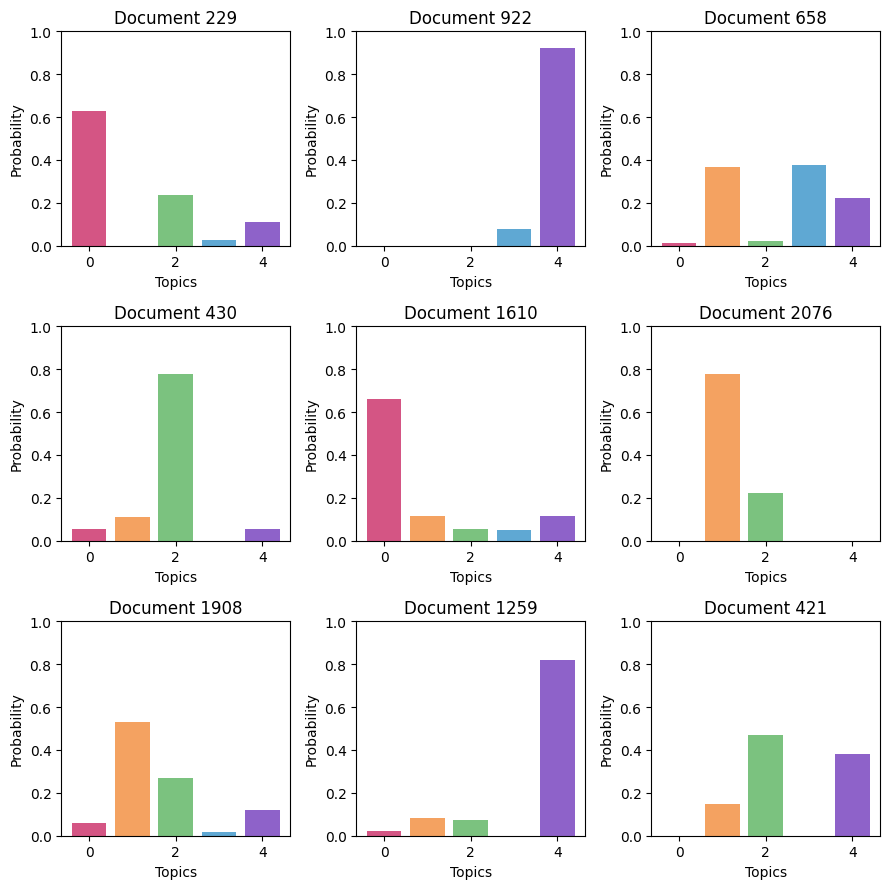

In [ ]:
np.random.seed(2025)

doc_list = np.random.randint(0, len(data), 15)

doc_list = np.random.randint(0, len(data), 9)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for m, theta in enumerate([probabilities[i] for i in doc_list]):
    row = m // 3
    col = m % 3
    axs[row, col].bar(range(len(theta)), theta, color=[topic_colors[j % len(topic_colors)] for j in range(len(theta))])
    axs[row, col].set_title(f'Document {doc_list[m]+1}')
    axs[row, col].set_xlabel('Topics')
    axs[row, col].set_ylabel('Probability')
    axs[row, col].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 3) Document Visualization

In [ ]:
doc_list = [156, 800, 1059, 1500, 2000]

for doc in doc_list:
    doc_html = document_visualizaion(model, data, doc-1, 1)
    display(HTML(f"<html><body>{doc_html}</body></html>"))

# Evaluation Metrics
- Accuracy
- ARI (Adjusted Rand Index)
- NMI (Normalized Mutual Information)

In [ ]:
pred_topic = topics
true_topic = news_data['category']

count_matrix = pd.crosstab(pred_topic, true_topic)
count_matrix

category,business,entertainment,politics,sport,tech
row_0,,,,,
0,8,1,3,508,3
1,15,14,3,0,380
2,463,2,7,1,11
3,1,368,0,0,3
4,23,1,404,2,4


In [ ]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


# Assignment pseudo-label
cost = - count_matrix.values

# Hungarian Algorithm
row_ind, col_ind = linear_sum_assignment(cost)

# mapping: pred_topic(row) → true_topic(col)
mapping = {int(row): count_matrix.columns[int(col)] for row, col in zip(row_ind, col_ind)}
mapped_pred_topic = np.array([mapping[p] for p in pred_topic])

# accuracy
accuracy = np.mean(mapped_pred_topic == true_topic)
print(f"Accuracy: {accuracy:.3f}")


# ARI
ari = adjusted_rand_score(true_topic, mapped_pred_topic)
print(f"ARI Score: {ari:.3f}")


# NMI
nmi = normalized_mutual_info_score(true_topic, mapped_pred_topic)
print(f"NMI Score: {nmi:.3f}")

Accuracy: 0.954
ARI Score: 0.890
NMI Score: 0.862
